Scaling down `overall_rating` to 3-class and creates in `satisfaction_class`

In [1]:
import os
import pandas as pd
import numpy as np

INPUT_CSV = "/content/drive/MyDrive/PR_Sky/Dataset/airport.csv"
OUT_DIR   = "/content/drive/MyDrive/PR_Sky"

if not os.path.exists(OUT_DIR):
    os.makedirs(OUT_DIR)

df = pd.read_csv(INPUT_CSV)

df["overall_rating"] = pd.to_numeric(df["overall_rating"], errors="coerce")

df = df.dropna(subset=["overall_rating"])

satisfaction_list = []

for r in df["overall_rating"]:
    if r <= 4:
        satisfaction_list.append(0)
    elif r <= 7:
        satisfaction_list.append(1)
    else:
        satisfaction_list.append(2)

df["satisfaction_class"] = satisfaction_list

out_path = os.path.join(OUT_DIR, "airport_with_target.csv")
df.to_csv(out_path, index=False)

print("Final dataset shape:", df.shape)

print("\nClass distribution (counts):")
print(df["satisfaction_class"].value_counts().sort_index())

print("\nClass distribution (proportion):")
print(df["satisfaction_class"].value_counts(normalize=True).sort_index().round(3))

print("\nSaved:", out_path)

Final dataset shape: (13796, 21)

Class distribution (counts):
satisfaction_class
0    8575
1    2728
2    2493
Name: count, dtype: int64

Class distribution (proportion):
satisfaction_class
0    0.622
1    0.198
2    0.181
Name: proportion, dtype: float64

Saved: /content/drive/MyDrive/PR_Sky/airport_with_target.csv


# Path way to Gaussian Naive Bayes

Load & sanity check (NO training yet)

In [2]:
import os
import numpy as np
import pandas as pd

BASE = "/content/drive/MyDrive/PR_Sky"
IN_CSV = os.path.join(BASE, "airport_with_target.csv")

df = pd.read_csv(IN_CSV)

print("Shape:", df.shape)
print("Columns:", list(df.columns))

if "satisfaction_class" not in df.columns:
    print("satisfaction_class not found. Create it from overall_rating first.")
    raise SystemExit()

df["satisfaction_class"] = pd.to_numeric(df["satisfaction_class"], errors="coerce")

bad_rows = []
for i in range(len(df)):
    val = df["satisfaction_class"].iloc[i]
    if pd.isna(val) or (val not in [0, 1, 2]):
        bad_rows.append(i)

if len(bad_rows) > 0:
    print("Warning Found", len(bad_rows), "rows with invalid satisfaction_class, dropping them")
    df = df.drop(bad_rows)

print("\nClass distribution (counts):")
print(df["satisfaction_class"].value_counts().sort_index())

print("\nClass distribution (proportions):")
print(df["satisfaction_class"].value_counts(normalize=True).sort_index().round(3))

numeric_feature_candidates = [
    "queuing_rating",
    "terminal_cleanliness_rating",
    "terminal_seating_rating",
    "terminal_signs_rating",
    "food_beverages_rating",
    "airport_shopping_rating",
    "wifi_connectivity_rating",
    "airport_staff_rating",
]

numeric_cols = []
for c in numeric_feature_candidates:
    if c in df.columns:
        numeric_cols.append(c)

if len(numeric_cols) == 0:
    print("No numeric rating features found. Check your dataset columns.")
    raise SystemExit()

for c in numeric_cols:
    df[c] = pd.to_numeric(df[c], errors="coerce")

print("\nNumeric features to use (excluding overall_rating):", numeric_cols)

missing_percents = {}
for c in numeric_cols:
    total = len(df)
    missing = df[c].isna().sum()
    percent = missing / total
    missing_percents[c] = percent

print("\nMissingness (numeric features):")
for c in sorted(missing_percents, key=missing_percents.get, reverse=True):
    print(c, ":", round(missing_percents[c], 3))

too_missing = []
for c in numeric_cols:
    if missing_percents[c] > 0.5:
        too_missing.append(c)

if len(too_missing) > 0:
    print("\nNOTE: These features have >50% missing values and may hurt GNB:")
    print(too_missing)
    print("You can drop them or fill missing values in preprocessing.")

print("\nSample rows (head):")
cols_show = ["satisfaction_class"] + numeric_cols
print(df[cols_show].head(10))

OUT_CSV = os.path.join(BASE, "airport_with_target__checked.csv")
df.to_csv(OUT_CSV, index=False)
print("\nSaved checked dataset to:", OUT_CSV)

Shape: (13796, 21)
Columns: ['airport_name', 'link', 'title', 'author', 'author_country', 'date', 'content', 'experience_airport', 'date_visit', 'type_traveller', 'overall_rating', 'queuing_rating', 'terminal_cleanliness_rating', 'terminal_seating_rating', 'terminal_signs_rating', 'food_beverages_rating', 'airport_shopping_rating', 'wifi_connectivity_rating', 'airport_staff_rating', 'recommended', 'satisfaction_class']

Class distribution (counts):
satisfaction_class
0    8575
1    2728
2    2493
Name: count, dtype: int64

Class distribution (proportions):
satisfaction_class
0    0.622
1    0.198
2    0.181
Name: proportion, dtype: float64

Numeric features to use (excluding overall_rating): ['queuing_rating', 'terminal_cleanliness_rating', 'terminal_seating_rating', 'terminal_signs_rating', 'food_beverages_rating', 'airport_shopping_rating', 'wifi_connectivity_rating', 'airport_staff_rating']

Missingness (numeric features):
airport_staff_rating : 0.998
terminal_signs_rating : 0.998
w

Preprocessing & Feature Engineering

In [3]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

BASE = "/content/drive/MyDrive/PR_Sky"
IN_CSV = os.path.join(BASE, "airport_with_target__checked.csv")
OUT_DIR = BASE

if not os.path.exists(OUT_DIR):
    os.makedirs(OUT_DIR)

df = pd.read_csv(IN_CSV)

target = "satisfaction_class"

all_possible = [
    "queuing_rating",
    "terminal_cleanliness_rating",
    "terminal_seating_rating",
    "terminal_signs_rating",
    "food_beverages_rating",
    "airport_shopping_rating",
    "wifi_connectivity_rating",
    "airport_staff_rating",
]

features = []
for c in all_possible:
    if c in df.columns:
        features.append(c)

X = df[features].copy()
y = pd.to_numeric(df[target], errors="coerce").astype(int)

imputer = SimpleImputer(strategy="median")
X_imputed = imputer.fit_transform(X)

X_proc = pd.DataFrame(X_imputed, columns=features, index=X.index)

print("\nClass distribution (counts):")
print(y.value_counts().sort_index())

print("\nClass distribution (proportions):")
print((y.value_counts(normalize=True).sort_index()).round(3))

X_train, X_test, y_train, y_test = train_test_split(
    X_proc, y, test_size=0.20, random_state=42, stratify=y
)

print("\nShapes: X_train:", X_train.shape, "X_test:", X_test.shape)

train = X_train.copy()
train[target] = y_train
test = X_test.copy()
test[target] = y_test

train_path = os.path.join(OUT_DIR, "airport_train_proc.csv")
test_path  = os.path.join(OUT_DIR, "airport_test_proc.csv")

train.to_csv(train_path, index=False)
test.to_csv(test_path, index=False)

print("\nSaved preprocessed datasets:")
print(" - Train:", train_path)
print(" - Test :", test_path)


Class distribution (counts):
satisfaction_class
0    8575
1    2728
2    2493
Name: count, dtype: int64

Class distribution (proportions):
satisfaction_class
0    0.622
1    0.198
2    0.181
Name: proportion, dtype: float64

Shapes: X_train: (11036, 8) X_test: (2760, 8)

Saved preprocessed datasets:
 - Train: /content/drive/MyDrive/PR_Sky/airport_train_proc.csv
 - Test : /content/drive/MyDrive/PR_Sky/airport_test_proc.csv


Gaussian Naive Bayes — Train, Predict, Evaluate

Train shape: (11036, 8)  Test shape: (2760, 8)
Classes in y_train: [np.int64(0), np.int64(1), np.int64(2)]
Classes in y_test : [np.int64(0), np.int64(1), np.int64(2)]

=== GaussianNB (Airport) — Test Metrics ===
Accuracy          : 0.7029
Macro F1          : 0.4920
Log-loss          : 1.1486
Brier (multiclass): 0.148224

=== Classification Report ===
              precision    recall  f1-score   support

           0     0.7265    0.9574    0.8262      1715
           1     0.2414    0.0256    0.0464       546
           2     0.6425    0.5691    0.6036       499

    accuracy                         0.7029      2760
   macro avg     0.5368    0.5174    0.4920      2760
weighted avg     0.6154    0.7029    0.6317      2760


Confusion Matrix (counts) [rows=true, cols=pred]:
 [[1642    7   66]
 [ 440   14   92]
 [ 178   37  284]]


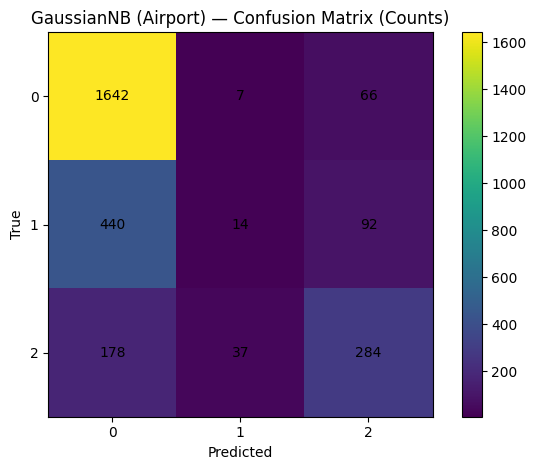

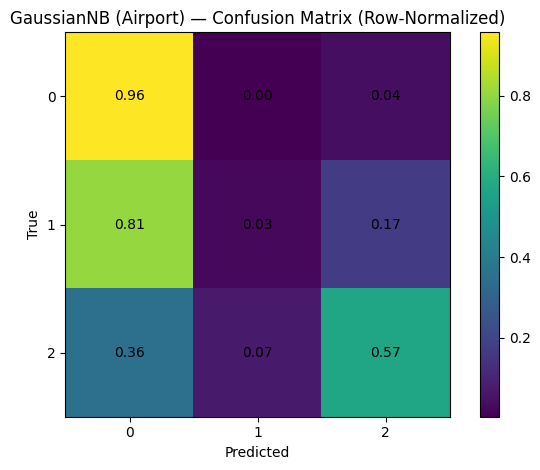

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (
    accuracy_score, f1_score, log_loss, confusion_matrix, classification_report
)

BASE_DIR = "/content/drive/MyDrive/PR_Sky"
TRAIN_CSV = os.path.join(BASE_DIR, "airport_train_proc.csv")
TEST_CSV  = os.path.join(BASE_DIR, "airport_test_proc.csv")

train = pd.read_csv(TRAIN_CSV)
test  = pd.read_csv(TEST_CSV)

target_col = "satisfaction_class"

X_train = train.drop(columns=[target_col]).copy()
y_train = train[target_col].astype(int).copy()
X_test  = test.drop(columns=[target_col]).copy()
y_test  = test[target_col].astype(int).copy()

print("Train shape:", X_train.shape, " Test shape:", X_test.shape)
print("Classes in y_train:", sorted(np.unique(y_train)))
print("Classes in y_test :", sorted(np.unique(y_test)))

gnb = GaussianNB()
gnb.fit(X_train, y_train)

y_pred  = gnb.predict(X_test)
y_proba = gnb.predict_proba(X_test)

acc = accuracy_score(y_test, y_pred)
f1_macro = f1_score(y_test, y_pred, average="macro")
ll = log_loss(y_test, y_proba, labels=gnb.classes_)

classes = gnb.classes_

class_to_index = {}
for i in range(len(classes)):
    c_val = classes[i]
    class_to_index[c_val] = i

y_true_onehot = np.zeros_like(y_proba)

for i in range(len(y_test)):
    yi = y_test.iloc[i]
    if yi in class_to_index:
        j = class_to_index[yi]
        y_true_onehot[i, j] = 1.0

brier_multiclass = np.mean((y_proba - y_true_onehot) ** 2)

print("\n=== GaussianNB (Airport) — Test Metrics ===")
print("Accuracy          : {:.4f}".format(acc))
print("Macro F1          : {:.4f}".format(f1_macro))
print("Log-loss          : {:.4f}".format(ll))
print("Brier (multiclass): {:.6f}".format(brier_multiclass))

print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred, digits=4))

cm = confusion_matrix(y_test, y_pred, labels=classes)
print("\nConfusion Matrix (counts) [rows=true, cols=pred]:\n", cm)

plt.figure()
plt.imshow(cm, interpolation="nearest")
plt.title("GaussianNB (Airport) — Confusion Matrix (Counts)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(range(len(classes)), classes)
plt.yticks(range(len(classes)), classes)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, str(cm[i, j]), ha="center", va="center")
plt.colorbar()
plt.tight_layout()
plt.show()

cm_float = cm.astype(float)
row_sums = cm_float.sum(axis=1, keepdims=True)
cm_norm = cm_float / row_sums

plt.figure()
plt.imshow(cm_norm, interpolation="nearest")
plt.title("GaussianNB (Airport) — Confusion Matrix (Row-Normalized)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(range(len(classes)), classes)
plt.yticks(range(len(classes)), classes)
for i in range(cm_norm.shape[0]):
    for j in range(cm_norm.shape[1]):
        plt.text(j, i, "{:.2f}".format(cm_norm[i, j]), ha="center", va="center")
plt.colorbar()
plt.tight_layout()
plt.show()

# Path way to Multinomial Naive Bayes

Load & Target Check

In [5]:
import os
import pandas as pd
import numpy as np

BASE = "/content/drive/MyDrive/PR_Sky"
IN_CSV = os.path.join(BASE, "airport_with_target.csv")

df = pd.read_csv(IN_CSV)

if "satisfaction_class" not in df.columns:
    print("Missing satisfaction_class — run target creation first.")
    raise SystemExit()

if "content" not in df.columns:
    print("Missing text column 'content'.")
    raise SystemExit()

df["content"] = df["content"].astype(str).str.strip()

df = df.dropna(subset=["satisfaction_class"]).copy()

mask_content = []
for i in range(len(df)):
    if len(df["content"].iloc[i]) > 0:
        mask_content.append(True)
    else:
        mask_content.append(False)
df = df[mask_content].copy()

df["satisfaction_class"] = pd.to_numeric(df["satisfaction_class"], errors="coerce")

mask_target = []
for i in range(len(df)):
    v = df["satisfaction_class"].iloc[i]
    if v in [0, 1, 2]:
        mask_target.append(True)
    else:
        mask_target.append(False)
df = df[mask_target].copy()

print("Shape after filtering:", df.shape)

print("\nClass distribution (counts):")
print(df["satisfaction_class"].value_counts().sort_index())

print("\nClass distribution (proportions):")
print(df["satisfaction_class"].value_counts(normalize=True).sort_index().round(3))

CHECKED_CSV = os.path.join(BASE, "airport_text_checked.csv")
df.to_csv(CHECKED_CSV, index=False)

print("\nSaved:", CHECKED_CSV)

Shape after filtering: (13796, 21)

Class distribution (counts):
satisfaction_class
0    8575
1    2728
2    2493
Name: count, dtype: int64

Class distribution (proportions):
satisfaction_class
0    0.622
1    0.198
2    0.181
Name: proportion, dtype: float64

Saved: /content/drive/MyDrive/PR_Sky/airport_text_checked.csv


Text preprocessing → Train/Test split → Word2Vec → KMeans BoC

In [6]:
!pip install gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 77.2 MB/s eta 0:00:00


In [7]:
import os
import re
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from gensim.models import Word2Vec
from sklearn.cluster import KMeans
from tqdm import tqdm

BASE = "/content/drive/MyDrive/PR_Sky"
IN_CSV = os.path.join(BASE, "airport_text_checked.csv")

df = pd.read_csv(IN_CSV)

_word_re = re.compile(r"[A-Za-z]+(?:'[A-Za-z]+)?")

all_tokens = []
for i in range(len(df)):
    text_here = str(df["content"].iloc[i]).lower()
    words_here = _word_re.findall(text_here)
    all_tokens.append(words_here)

df["tokens"] = all_tokens

mask_tokens = []
for i in range(len(df)):
    if len(df["tokens"].iloc[i]) > 0:
        mask_tokens.append(True)
    else:
        mask_tokens.append(False)
df = df[mask_tokens].copy()

y = df["satisfaction_class"].astype(int).values

tokens_list = df["tokens"].tolist()
X_train_tokens, X_test_tokens, y_train, y_test = train_test_split(
    tokens_list,
    y,
    test_size=0.20,
    random_state=42,
    stratify=y
)

print("Train docs:", len(X_train_tokens), " Test docs:", len(X_test_tokens))

w2v = Word2Vec(
    sentences=X_train_tokens,
    vector_size=100,
    window=5,
    min_count=2,
    workers=4,
    sg=0,
    epochs=10
)

vocab_words = list(w2v.wv.index_to_key)

print("Word2Vec vocab size:", len(vocab_words))

if len(vocab_words) > 0:
    word_vecs_list = []
    for w in vocab_words:
        word_vecs_list.append(w2v.wv[w])
    word_vecs = np.vstack(word_vecs_list)
else:
    word_vecs = np.zeros((0, 100))

if len(vocab_words) > 0:
    K_temp = len(vocab_words) // 5
    if K_temp < 50:
        K_temp = 50
    if K_temp > 300:
        K_temp = 300
    K = K_temp
else:
    K = 50

print("Clustering " + str(len(vocab_words)) + " word vectors into K=" + str(K) + " clusters...")

if len(vocab_words) > 0:
    kmeans = KMeans(n_clusters=K, n_init=10, random_state=42)
    kmeans.fit(word_vecs)
    word2cluster = {}
    for i in range(len(vocab_words)):
        w = vocab_words[i]
        c = int(kmeans.labels_[i])
        word2cluster[w] = c
else:
    word2cluster = {}

train_boc_list = []
for tokens in tqdm(X_train_tokens, desc="Train BoC"):
    counts = np.zeros(K, dtype=np.int32)
    for t in tokens:
        if t in word2cluster:
            cid = word2cluster[t]
            if cid >= 0 and cid < K:
                counts[cid] = counts[cid] + 1
    train_boc_list.append(counts)

X_train_boc = np.vstack(train_boc_list)

test_boc_list = []
for tokens in tqdm(X_test_tokens, desc="Test BoC"):
    counts = np.zeros(K, dtype=np.int32)
    for t in tokens:
        if t in word2cluster:
            cid = word2cluster[t]
            if cid >= 0 and cid < K:
                counts[cid] = counts[cid] + 1
    test_boc_list.append(counts)

X_test_boc = np.vstack(test_boc_list)

print("X_train_boc shape:", X_train_boc.shape, " X_test_boc shape:", X_test_boc.shape)

np.save(os.path.join(BASE, "airport_X_train_boc.npy"), X_train_boc)
np.save(os.path.join(BASE, "airport_X_test_boc.npy"),  X_test_boc)
np.save(os.path.join(BASE, "airport_y_train.npy"),     y_train)
np.save(os.path.join(BASE, "airport_y_test.npy"),      y_test)

cluster_map_path = os.path.join(BASE, "airport_word2cluster.tsv")
f = open(cluster_map_path, "w", encoding="utf-8")
f.write("word\tcluster\n")
for w in vocab_words:
    line = w + "\t" + str(word2cluster[w]) + "\n"
    f.write(line)
f.close()

print("\nSaved:")
print(" -", os.path.join(BASE, "airport_X_train_boc.npy"))
print(" -", os.path.join(BASE, "airport_X_test_boc.npy"))
print(" -", os.path.join(BASE, "airport_y_train.npy"))
print(" -", os.path.join(BASE, "airport_y_test.npy"))
print(" -", cluster_map_path)

Train docs: 11036  Test docs: 2760
Word2Vec vocab size: 11948
Clustering 11948 word vectors into K=300 clusters...


Test BoC: 100%|██████████| 2760/2760 [00:00<00:00, 9051.90it/s]

X_train_boc shape: (11036, 300)  X_test_boc shape: (2760, 300)

Saved:
 - /content/drive/MyDrive/PR_Sky/airport_X_train_boc.npy
 - /content/drive/MyDrive/PR_Sky/airport_X_test_boc.npy
 - /content/drive/MyDrive/PR_Sky/airport_y_train.npy
 - /content/drive/MyDrive/PR_Sky/airport_y_test.npy
 - /content/drive/MyDrive/PR_Sky/airport_word2cluster.tsv


Multinomial Naive Bayes

Shapes: (11036, 300) (2760, 300) (11036,) (2760,)

Best alpha: 2.0
Accuracy  : 0.6083
Macro F1  : 0.4996
Log-loss  : 1.4929

Classification Report (best alpha):
              precision    recall  f1-score   support

           0     0.7994    0.7201    0.7577      1715
           1     0.2984    0.2088    0.2457       546
           2     0.3962    0.6613    0.4955       499

    accuracy                         0.6083      2760
   macro avg     0.4980    0.5301    0.4996      2760
weighted avg     0.6274    0.6083    0.6090      2760


Confusion Matrix (counts) [rows=true, cols=pred]:
 [[1235  191  289]
 [ 218  114  214]
 [  92   77  330]]


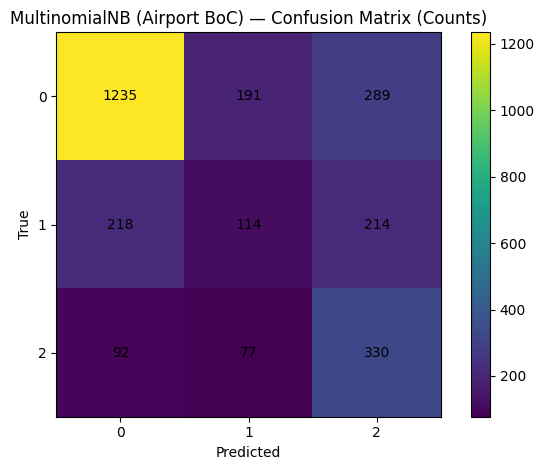

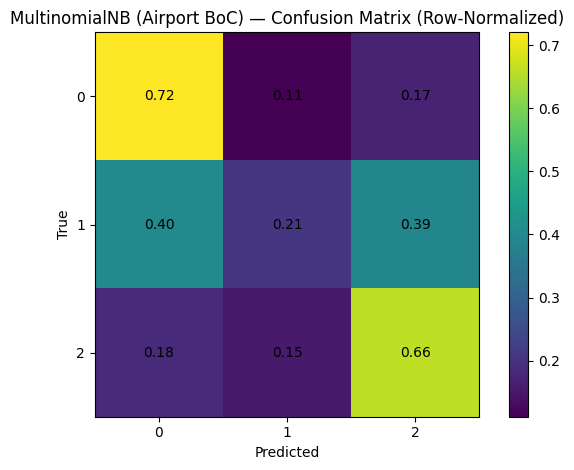

In [8]:
import os
import numpy as np
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, f1_score, log_loss, classification_report, confusion_matrix
import matplotlib.pyplot as plt

BASE = "/content/drive/MyDrive/PR_Sky"

X_train = np.load(os.path.join(BASE, "airport_X_train_boc.npy"))
X_test  = np.load(os.path.join(BASE, "airport_X_test_boc.npy"))
y_train = np.load(os.path.join(BASE, "airport_y_train.npy"))
y_test  = np.load(os.path.join(BASE, "airport_y_test.npy"))

print("Shapes:", X_train.shape, X_test.shape, y_train.shape, y_test.shape)

alphas = [0.05, 0.1, 0.5, 1.0, 2.0]

best_alpha = None
best_acc = None
best_f1 = None
best_logloss = None
best_model = None

for a in alphas:
    clf = MultinomialNB(alpha=a)
    clf.fit(X_train, y_train)

    y_pred_loop  = clf.predict(X_test)
    y_proba_loop = clf.predict_proba(X_test)

    acc_loop = accuracy_score(y_test, y_pred_loop)
    f1m_loop = f1_score(y_test, y_pred_loop, average="macro")
    ll_loop  = log_loss(y_test, y_proba_loop, labels=clf.classes_)

    if best_alpha is None:
        best_alpha = a
        best_acc = acc_loop
        best_f1 = f1m_loop
        best_logloss = ll_loop
        best_model = clf
    else:
        if ll_loop < best_logloss:
            best_alpha = a
            best_acc = acc_loop
            best_f1 = f1m_loop
            best_logloss = ll_loop
            best_model = clf

print("\nBest alpha: {}".format(best_alpha))
print("Accuracy  : {:.4f}".format(best_acc))
print("Macro F1  : {:.4f}".format(best_f1))
print("Log-loss  : {:.4f}".format(best_logloss))

best_clf = best_model
y_pred  = best_clf.predict(X_test)
y_proba = best_clf.predict_proba(X_test)

print("\nClassification Report (best alpha):")
print(classification_report(y_test, y_pred, digits=4))

cm = confusion_matrix(y_test, y_pred, labels=best_clf.classes_)
print("\nConfusion Matrix (counts) [rows=true, cols=pred]:\n", cm)

plt.figure()
plt.imshow(cm, interpolation="nearest")
plt.colorbar()
plt.title("MultinomialNB (Airport BoC) — Confusion Matrix (Counts)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(range(len(best_clf.classes_)), best_clf.classes_)
plt.yticks(range(len(best_clf.classes_)), best_clf.classes_)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, str(cm[i, j]), ha="center", va="center")
plt.tight_layout()
plt.show()

cmn = cm.astype(float) / cm.sum(axis=1, keepdims=True)
plt.figure()
plt.imshow(cmn, interpolation="nearest")
plt.colorbar()
plt.title("MultinomialNB (Airport BoC) — Confusion Matrix (Row-Normalized)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(range(len(best_clf.classes_)), best_clf.classes_)
plt.yticks(range(len(best_clf.classes_)), best_clf.classes_)
for i in range(cmn.shape[0]):
    for j in range(cm.shape[1]):
        txt = "{:.2f}".format(cmn[i, j])
        plt.text(j, i, txt, ha="center", va="center")
plt.tight_layout()
plt.show()

# Path way to Bernoulli Naive Bayes

Feature Selection + Preprocessing to Binary Matrix

In [9]:
import os
import re
import json
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from scipy.sparse import csr_matrix, save_npz

BASE = "/content/drive/MyDrive/PR_Sky"
IN_CSV = os.path.join(BASE, "airport_with_target.csv")
OUT_DIR = BASE

if not os.path.exists(OUT_DIR):
    os.makedirs(OUT_DIR)

df = pd.read_csv(IN_CSV)

if "satisfaction_class" not in df.columns:
    print("Run target creation first.")
    raise SystemExit()

y_all = pd.to_numeric(df["satisfaction_class"], errors="coerce")
df = df[~y_all.isna()].copy()
y_all = y_all.astype(int).values

CANDIDATES = [
    "type_traveller",
    "airport_name",
    "experience_airport",
    "author_country",
    "airline_name",
]

present = []
for c in CANDIDATES:
    if c in df.columns:
        present.append(c)

if len(present) == 0:
    raise ValueError("No categorical features found for BernoulliNB.")

print("Using categorical features:", present)

for c in present:
    new_vals = []
    for v in df[c]:
        if pd.isna(v):
            new_vals.append("unknown")
        else:
            s = str(v)
            s = s.strip().lower()
            s = re.sub(r"\s+", " ", s)
            if s == "":
                new_vals.append("unknown")
            else:
                new_vals.append(s)
    df[c] = new_vals

TOPK = 75
for c in present:
    vc = df[c].value_counts()
    top_vals = vc.head(TOPK).index.tolist()
    keep_set = set(top_vals)

    new_vals = []
    for v in df[c]:
        if v in keep_set:
            new_vals.append(v)
        else:
            new_vals.append("other")
    df[c] = new_vals

try:
    enc = OneHotEncoder(handle_unknown="ignore", sparse_output=True, dtype=np.uint8)
except TypeError:
    enc = OneHotEncoder(handle_unknown="ignore", sparse=True, dtype=np.uint8)

X_all_sparse = enc.fit_transform(df[present])

feature_names = enc.get_feature_names_out(present).tolist()
featmap_path = os.path.join(OUT_DIR, "airport_bnb_feature_names.json")
with open(featmap_path, "w", encoding="utf-8") as f:
    json.dump(feature_names, f, ensure_ascii=False, indent=2)

print("Binary matrix shape:", X_all_sparse.shape)
print("Saved feature names:", featmap_path)

X_tr, X_te, y_tr, y_te = train_test_split(
    X_all_sparse, y_all, test_size=0.20, random_state=42, stratify=y_all
)

train_npz = os.path.join(OUT_DIR, "airport_BNB_X_train.npz")
test_npz  = os.path.join(OUT_DIR, "airport_BNB_X_test.npz")
save_npz(train_npz, csr_matrix(X_tr))
save_npz(test_npz,  csr_matrix(X_te))

np.save(os.path.join(OUT_DIR, "airport_BNB_y_train.npy"), y_tr)
np.save(os.path.join(OUT_DIR, "airport_BNB_y_test.npy"),  y_te)

print("\nSaved:")
print(" -", train_npz)
print(" -", test_npz)
print(" -", os.path.join(OUT_DIR, "airport_BNB_y_train.npy"))
print(" -", os.path.join(OUT_DIR, "airport_BNB_y_test.npy"))

Using categorical features: ['type_traveller', 'airport_name', 'experience_airport', 'author_country']
Binary matrix shape: (13796, 162)
Saved feature names: /content/drive/MyDrive/PR_Sky/airport_bnb_feature_names.json

Saved:
 - /content/drive/MyDrive/PR_Sky/airport_BNB_X_train.npz
 - /content/drive/MyDrive/PR_Sky/airport_BNB_X_test.npz
 - /content/drive/MyDrive/PR_Sky/airport_BNB_y_train.npy
 - /content/drive/MyDrive/PR_Sky/airport_BNB_y_test.npy


Train, Evaluate, Interpret

Shapes: (11036, 162) (2760, 162) (11036,) (2760,)

Best alpha: 2.0
Accuracy  : 0.6236
Macro F1  : 0.3641
Log-loss  : 0.8624

=== Classification Report (best alpha) ===
              precision    recall  f1-score   support

           0     0.6549    0.9382    0.7713      1715
           1     0.3291    0.0476    0.0832       546
           2     0.3839    0.1723    0.2379       499

    accuracy                         0.6236      2760
   macro avg     0.4560    0.3861    0.3641      2760
weighted avg     0.5414    0.6236    0.5388      2760


Confusion Matrix (counts) [rows=true, cols=pred]:
 [[1609   25   81]
 [ 463   26   57]
 [ 385   28   86]]


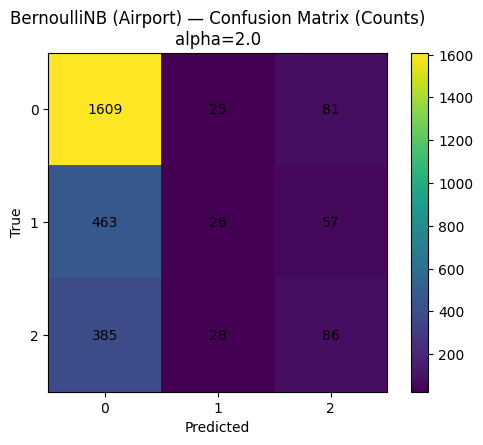

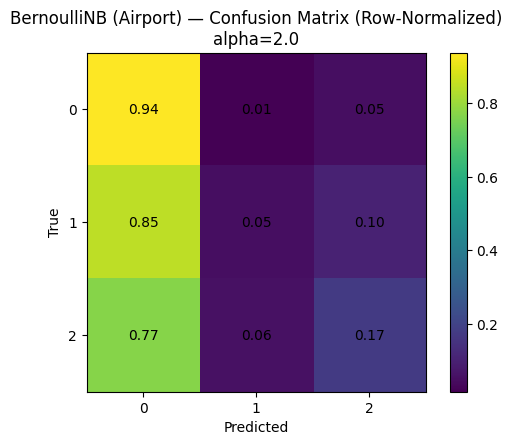


Top 15 features for class=0 (feat, logP(x=1|c), Δ_vs_others):
  author_country_unknown                              -1.246   Δ=+2.234
  airport_name_dalaman-airport                        -5.223   Δ=+1.270
  airport_name_sharm-el-sheikh-airport                -5.196   Δ=+1.206
  airport_name_newark-airport                         -4.490   Δ=+1.083
  airport_name_bournemouth-airport                    -4.845   Δ=+0.955
  airport_name_luton-airport                          -4.014   Δ=+0.932
  airport_name_milan-malpensa-airport                 -5.223   Δ=+0.899
  airport_name_miami-airport                          -4.403   Δ=+0.823
  type_traveller_couple leisure                       -4.080   Δ=+0.798
  experience_airport_arrival only                     -5.170   Δ=+0.774
  airport_name_los-angeles-lax-airport                -4.107   Δ=+0.680
  airport_name_london-stansted-airport                -3.765   Δ=+0.675
  airport_name_paris-cdg-airport                      -3.778   Δ=+0.594
 

In [10]:
import os
import json
import numpy as np
from scipy.sparse import load_npz
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    log_loss,
    classification_report,
    confusion_matrix,
)
import matplotlib.pyplot as plt

BASE = "/content/drive/MyDrive/PR_Sky"
XTR = os.path.join(BASE, "airport_BNB_X_train.npz")
XTE = os.path.join(BASE, "airport_BNB_X_test.npz")
ytr = os.path.join(BASE, "airport_BNB_y_train.npy")
yte = os.path.join(BASE, "airport_BNB_y_test.npy")
featmap_path = os.path.join(BASE, "airport_bnb_feature_names.json")

X_train = load_npz(XTR)
X_test  = load_npz(XTE)
y_train = np.load(ytr)
y_test  = np.load(yte)

f = open(featmap_path, "r", encoding="utf-8")
feature_names = json.load(f)
f.close()

print("Shapes:", X_train.shape, X_test.shape, y_train.shape, y_test.shape)

alphas = [0.25, 0.5, 1.0, 1.5, 2.0]

best_alpha = None
best_acc = None
best_f1 = None
best_logloss = None
best_model = None

for a in alphas:
    clf = BernoulliNB(alpha=a)
    clf.fit(X_train, y_train)

    y_pred_loop = clf.predict(X_test)
    y_proba_loop = clf.predict_proba(X_test)

    acc_loop = accuracy_score(y_test, y_pred_loop)
    f1m_loop = f1_score(y_test, y_pred_loop, average="macro")
    ll_loop  = log_loss(y_test, y_proba_loop, labels=clf.classes_)

    if best_alpha is None:
        best_alpha = a
        best_acc = acc_loop
        best_f1 = f1m_loop
        best_logloss = ll_loop
        best_model = clf
    else:
        if ll_loop < best_logloss:
            best_alpha = a
            best_acc = acc_loop
            best_f1 = f1m_loop
            best_logloss = ll_loop
            best_model = clf

print("\nBest alpha: {}".format(best_alpha))
print("Accuracy  : {:.4f}".format(best_acc))
print("Macro F1  : {:.4f}".format(best_f1))
print("Log-loss  : {:.4f}".format(best_logloss))

best_clf = best_model
y_pred  = best_clf.predict(X_test)
y_proba = best_clf.predict_proba(X_test)

print("\n=== Classification Report (best alpha) ===")
print(classification_report(y_test, y_pred, digits=4))

classes = best_clf.classes_
cm = confusion_matrix(y_test, y_pred, labels=classes)
print("\nConfusion Matrix (counts) [rows=true, cols=pred]:\n", cm)

plt.figure(figsize=(5.5, 4.5))
plt.imshow(cm, interpolation="nearest")
plt.title("BernoulliNB (Airport) — Confusion Matrix (Counts)\nalpha=" + str(best_alpha))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(range(len(classes)), classes)
plt.yticks(range(len(classes)), classes)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, str(cm[i, j]), ha="center", va="center")
plt.colorbar()
plt.tight_layout()
plt.show()

cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)
plt.figure(figsize=(5.5, 4.5))
plt.imshow(cm_norm, interpolation="nearest")
plt.title("BernoulliNB (Airport) — Confusion Matrix (Row-Normalized)\nalpha=" + str(best_alpha))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(range(len(classes)), classes)
plt.yticks(range(len(classes)), classes)
for i in range(cm_norm.shape[0]):
    for j in range(cm_norm.shape[1]):
        txt_val = "{:.2f}".format(cm_norm[i, j])
        plt.text(j, i, txt_val, ha="center", va="center")
plt.colorbar()
plt.tight_layout()
plt.show()

log_prob = best_clf.feature_log_prob_

KSHOW = 15

for i in range(len(classes)):
    class_logp = log_prob[i]

    all_idx = np.arange(log_prob.shape[0])
    other_idx_list = []
    for j in range(len(all_idx)):
        if j != i:
            other_idx_list.append(all_idx[j])
    other_idx = np.array(other_idx_list)

    mean_other = log_prob[other_idx].mean(axis=0)

    delta = class_logp - mean_other

    order = np.argsort(delta)[::-1]
    top_idx = order[:KSHOW]

    print(
        "\nTop {} features for class={} (feat, logP(x=1|c), Δ_vs_others):".format(
            KSHOW, classes[i]
        )
    )

    for j in top_idx:
        name = feature_names[j]
        lp = float(class_logp[j])
        dd = float(delta[j])
        print("  {0:50s}  {1:+.3f}   Δ={2:+.3f}".format(name, lp, dd))

# Path way to Hybrid Model: Combining structured numeric and text features

LOAD DATASET numeric + Text

In [11]:
import os
import re
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
import pickle

BASE = "/content/drive/MyDrive/PR_Sky"
IN_CSV = os.path.join(BASE, "airport_with_target.csv")
OUT = BASE

if not os.path.exists(OUT):
    os.makedirs(OUT)

df = pd.read_csv(IN_CSV)

if "satisfaction_class" not in df.columns:
    print("Run target creation first.")
    raise SystemExit()

df["satisfaction_class"] = pd.to_numeric(df["satisfaction_class"], errors="coerce")

mask_target = []
for i in range(len(df)):
    v = df["satisfaction_class"].iloc[i]
    if v in [0, 1, 2]:
        mask_target.append(True)
    else:
        mask_target.append(False)

df = df[mask_target].copy()

if "content" not in df.columns:
    print("Expected text column 'content'.")
    raise SystemExit()

df["content"] = df["content"].astype(str).str.strip()

_word_re = re.compile(r"[A-Za-z]+(?:'[A-Za-z]+)?")

all_tokens = []
for i in range(len(df)):
    text_here = str(df["content"].iloc[i]).lower()
    words_here = _word_re.findall(text_here)
    all_tokens.append(words_here)

df["tokens"] = all_tokens

mask_tokens = []
for i in range(len(df)):
    if len(df["tokens"].iloc[i]) > 0:
        mask_tokens.append(True)
    else:
        mask_tokens.append(False)

df = df[mask_tokens].copy()

NUMERIC_FEATURES = [
    "queuing_rating",
    "terminal_cleanliness_rating",
    "airport_shopping_rating",
]

for c in NUMERIC_FEATURES:
    if c not in df.columns:
        df[c] = np.nan
    df[c] = pd.to_numeric(df[c], errors="coerce")

imp = SimpleImputer(strategy="median")
X_num_full_array = imp.fit_transform(df[NUMERIC_FEATURES])
X_num_full = pd.DataFrame(X_num_full_array, columns=NUMERIC_FEATURES, index=df.index)

y_full = df["satisfaction_class"].astype(int).values

idx = np.arange(len(df))
idx_train, idx_test = train_test_split(
    idx, test_size=0.20, random_state=42, stratify=y_full
)

df_train = df.iloc[idx_train].copy()
df_test = df.iloc[idx_test].copy()

np.save(os.path.join(OUT, "airport_hybrid_idx_train.npy"), idx_train)
np.save(os.path.join(OUT, "airport_hybrid_idx_test.npy"), idx_test)

np.save(os.path.join(OUT, "airport_hybrid_Xnum_train.npy"), X_num_full.iloc[idx_train].values)
np.save(os.path.join(OUT, "airport_hybrid_Xnum_test.npy"), X_num_full.iloc[idx_test].values)
np.save(os.path.join(OUT, "airport_hybrid_y_train.npy"), y_full[idx_train])
np.save(os.path.join(OUT, "airport_hybrid_y_test.npy"), y_full[idx_test])

f_train = open(os.path.join(OUT, "airport_hybrid_tokens_train.pkl"), "wb")
pickle.dump(df_train["tokens"].tolist(), f_train)
f_train.close()

f_test = open(os.path.join(OUT, "airport_hybrid_tokens_test.pkl"), "wb")
pickle.dump(df_test["tokens"].tolist(), f_test)
f_test.close()

print("Unified aligned split created.")
print("Train size:", len(idx_train), " Test size:", len(idx_test))
print("Saved aligned artifacts to:", OUT)

Unified aligned split created.
Train size: 11036  Test size: 2760
Saved aligned artifacts to: /content/drive/MyDrive/PR_Sky


GAUSSIAN NB (numeric branch on the aligned split)

In [12]:
import os
import numpy as np
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, f1_score, log_loss, classification_report, confusion_matrix

BASE = "/content/drive/MyDrive/PR_Sky"

Xtr = np.load(os.path.join(BASE, "airport_hybrid_Xnum_train.npy"))
Xte = np.load(os.path.join(BASE, "airport_hybrid_Xnum_test.npy"))
ytr = np.load(os.path.join(BASE, "airport_hybrid_y_train.npy"))
yte = np.load(os.path.join(BASE, "airport_hybrid_y_test.npy"))

print("Numeric shapes:", Xtr.shape, Xte.shape)

gnb = GaussianNB()
gnb.fit(Xtr, ytr)

y_pred_g = gnb.predict(Xte)
y_proba_g = gnb.predict_proba(Xte)
classes_g = gnb.classes_

acc = accuracy_score(yte, y_pred_g)
f1m = f1_score(yte, y_pred_g, average="macro")
ll  = log_loss(yte, y_proba_g, labels=classes_g)

print("\n[GaussianNB] Test Accuracy:", "{:.4f}".format(acc))
print("[GaussianNB] Macro F1    :", "{:.4f}".format(f1m))
print("[GaussianNB] Log-loss    :", "{:.4f}".format(ll))

print("\nClassification Report (GNB):\n", classification_report(yte, y_pred_g, digits=4))

cm = confusion_matrix(yte, y_pred_g, labels=classes_g)
print("Confusion Matrix (GNB):\n", cm)

np.save(os.path.join(BASE, "airport_hybrid_proba_g.npy"),   y_proba_g)
np.save(os.path.join(BASE, "airport_hybrid_classes_g.npy"), classes_g)
print("Saved GNB probabilities for hybrid.")

Numeric shapes: (11036, 3) (2760, 3)

[GaussianNB] Test Accuracy: 0.7565
[GaussianNB] Macro F1    : 0.6106
[GaussianNB] Log-loss    : 0.7005

Classification Report (GNB):
               precision    recall  f1-score   support

           0     0.8389    0.9172    0.8763      1715
           1     0.4684    0.1630    0.2418       546
           2     0.6129    0.8537    0.7136       499

    accuracy                         0.7565      2760
   macro avg     0.6401    0.6446    0.6106      2760
weighted avg     0.7248    0.7565    0.7214      2760

Confusion Matrix (GNB):
 [[1573   50   92]
 [ 280   89  177]
 [  22   51  426]]
Saved GNB probabilities for hybrid.


MULTINOMIAL NB (text branch on the aligned split)

In [13]:
import os
import pickle
import numpy as np
from gensim.models import Word2Vec
from sklearn.cluster import KMeans
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, f1_score, log_loss, classification_report, confusion_matrix
from tqdm import tqdm
import json

BASE = "/content/drive/MyDrive/PR_Sky"

f_train = open(os.path.join(BASE, "airport_hybrid_tokens_train.pkl"), "rb")
X_train_tokens = pickle.load(f_train)
f_train.close()

f_test = open(os.path.join(BASE, "airport_hybrid_tokens_test.pkl"), "rb")
X_test_tokens = pickle.load(f_test)
f_test.close()

ytr = np.load(os.path.join(BASE, "airport_hybrid_y_train.npy"))
yte = np.load(os.path.join(BASE, "airport_hybrid_y_test.npy"))

print("Docs:", len(X_train_tokens), "(train),", len(X_test_tokens), "(test)")

w2v = Word2Vec(
    sentences=X_train_tokens,
    vector_size=100,
    window=5,
    min_count=2,
    workers=4,
    sg=0,
    epochs=10
)

vocab_words = list(w2v.wv.index_to_key)
print("Word2Vec vocab size:", len(vocab_words))

if len(vocab_words) > 0:
    word_vecs_list = []
    for w in vocab_words:
        word_vecs_list.append(w2v.wv[w])
    word_vecs = np.vstack(word_vecs_list)

    K_temp = len(vocab_words) // 5
    if K_temp < 50:
        K_temp = 50
    if K_temp > 300:
        K_temp = 300
    K = K_temp

    print("Clustering " + str(len(vocab_words)) + " words into K=" + str(K) + " clusters...")

    kmeans = KMeans(n_clusters=K, n_init=10, random_state=42)
    kmeans.fit(word_vecs)

    word2cluster = {}
    for i in range(len(vocab_words)):
        w = vocab_words[i]
        c = int(kmeans.labels_[i])
        word2cluster[w] = c
else:
    K = 50
    word2cluster = {}

train_boc_list = []
for tokens in tqdm(X_train_tokens, desc="BoC train"):
    v = np.zeros(K, dtype=np.int32)
    for t in tokens:
        if t in word2cluster:
            cid = word2cluster[t]
            if cid >= 0 and cid < K:
                v[cid] = v[cid] + 1
    train_boc_list.append(v)
Xtr_boc = np.vstack(train_boc_list)

test_boc_list = []
for tokens in tqdm(X_test_tokens, desc="BoC test"):
    v = np.zeros(K, dtype=np.int32)
    for t in tokens:
        if t in word2cluster:
            cid = word2cluster[t]
            if cid >= 0 and cid < K:
                v[cid] = v[cid] + 1
    test_boc_list.append(v)
Xte_boc = np.vstack(test_boc_list)

print("BoC shapes:", Xtr_boc.shape, Xte_boc.shape)

alphas = [0.05, 0.1, 0.5, 1.0, 2.0]

best_alpha = None
best_acc = None
best_f1 = None
best_logloss = None
best_model = None
best_proba = None
best_pred = None
best_classes = None

for a in alphas:
    mnb = MultinomialNB(alpha=a)
    mnb.fit(Xtr_boc, ytr)

    y_pred_m = mnb.predict(Xte_boc)
    y_proba_m = mnb.predict_proba(Xte_boc)

    acc = accuracy_score(yte, y_pred_m)
    f1m = f1_score(yte, y_pred_m, average="macro")
    ll = log_loss(yte, y_proba_m, labels=mnb.classes_)

    if best_alpha is None:
        best_alpha = a
        best_acc = acc
        best_f1 = f1m
        best_logloss = ll
        best_model = mnb
        best_proba = y_proba_m
        best_pred = y_pred_m
        best_classes = mnb.classes_
    else:
        if ll < best_logloss:
            best_alpha = a
            best_acc = acc
            best_f1 = f1m
            best_logloss = ll
            best_model = mnb
            best_proba = y_proba_m
            best_pred = y_pred_m
            best_classes = mnb.classes_

print("\n[MultinomialNB] Best alpha:", best_alpha)
print("[MultinomialNB] Accuracy  :", "{:.4f}".format(best_acc))
print("[MultinomialNB] Macro F1  :", "{:.4f}".format(best_f1))
print("[MultinomialNB] Log-loss  :", "{:.4f}".format(best_logloss))

print("\nClassification Report (MNB):\n", classification_report(yte, best_pred, digits=4))
cm = confusion_matrix(yte, best_pred, labels=best_classes)
print("Confusion Matrix (MNB):\n", cm)

np.save(os.path.join(BASE, "airport_hybrid_proba_m.npy"), best_proba)
np.save(os.path.join(BASE, "airport_hybrid_classes_m.npy"), best_classes)

info_dict = {"K": int(K)}
json_path = os.path.join(BASE, "airport_hybrid_word2cluster.json")
f_json = open(json_path, "w", encoding="utf-8")
json.dump(info_dict, f_json)
f_json.close()

print("Saved MNB probabilities for hybrid.")

Docs: 11036 (train), 2760 (test)
Word2Vec vocab size: 11948
Clustering 11948 words into K=300 clusters...


BoC test: 100%|██████████| 2760/2760 [00:00<00:00, 6803.55it/s]


BoC shapes: (11036, 300) (2760, 300)

[MultinomialNB] Best alpha: 2.0
[MultinomialNB] Accuracy  : 0.6054
[MultinomialNB] Macro F1  : 0.4988
[MultinomialNB] Log-loss  : 1.4329

Classification Report (MNB):
               precision    recall  f1-score   support

           0     0.7961    0.7149    0.7533      1715
           1     0.2836    0.2088    0.2405       546
           2     0.4046    0.6633    0.5027       499

    accuracy                         0.6054      2760
   macro avg     0.4948    0.5290    0.4988      2760
weighted avg     0.6239    0.6054    0.6065      2760

Confusion Matrix (MNB):
 [[1226  218  271]
 [ 216  114  216]
 [  98   70  331]]
Saved MNB probabilities for hybrid.


HYBRID — combine GaussianNB + MultinomialNB


=== HYBRID (GNB + MNB) Results ===
Best weight w (numeric share): 0.75
Accuracy  : 0.7572
Macro F1  : 0.6007
Log-loss  : 0.6615

Classification Report (HYBRID):
               precision    recall  f1-score   support

           0     0.8272    0.9242    0.8730      1715
           1     0.4795    0.1282    0.2023       546
           2     0.6232    0.8717    0.7268       499

    accuracy                         0.7572      2760
   macro avg     0.6433    0.6414    0.6007      2760
weighted avg     0.7216    0.7572    0.7139      2760

Confusion Matrix (HYBRID):
 [[1585   40   90]
 [ 303   70  173]
 [  28   36  435]]
Saved blended probabilities & classes.
Figures will be saved under: /content/drive/MyDrive/PR_Sky/figs_hybrid


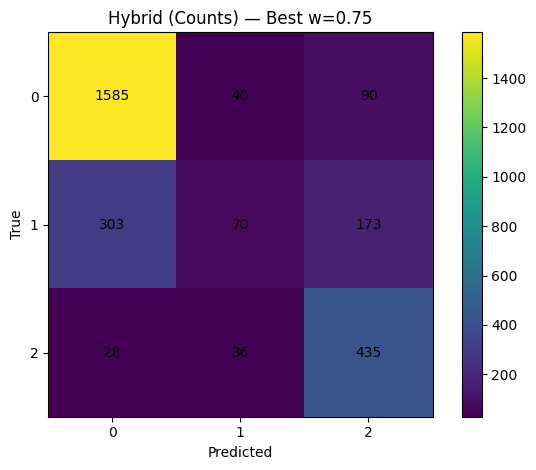

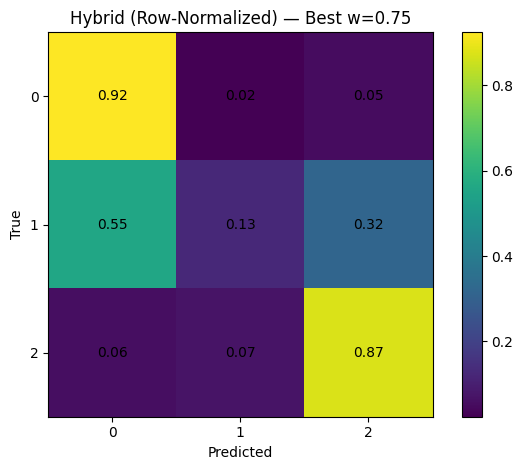

In [14]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, log_loss, confusion_matrix, classification_report

BASE = "/content/drive/MyDrive/PR_Sky"
FIG_DIR = os.path.join(BASE, "figs_hybrid")

if not os.path.exists(FIG_DIR):
    os.makedirs(FIG_DIR)

yte = np.load(os.path.join(BASE, "airport_hybrid_y_test.npy"))

proba_g = np.load(os.path.join(BASE, "airport_hybrid_proba_g.npy"))
cls_g   = np.load(os.path.join(BASE, "airport_hybrid_classes_g.npy"))

proba_m = np.load(os.path.join(BASE, "airport_hybrid_proba_m.npy"))
cls_m   = np.load(os.path.join(BASE, "airport_hybrid_classes_m.npy"))

ALL_CLASSES = np.array(sorted(set(cls_g.tolist()) | set(cls_m.tolist())))

Pg = np.zeros((proba_g.shape[0], len(ALL_CLASSES)), dtype=float)
for j in range(len(cls_g)):
    c_val = cls_g[j]
    tgt_idx = None
    for t in range(len(ALL_CLASSES)):
        if ALL_CLASSES[t] == c_val:
            tgt_idx = t
            break
    if tgt_idx is not None:
        Pg[:, tgt_idx] = proba_g[:, j]

for i in range(Pg.shape[0]):
    for j in range(Pg.shape[1]):
        if Pg[i, j] < 1e-12:
            Pg[i, j] = 1e-12
    row_sum = Pg[i].sum()
    if row_sum > 0:
        Pg[i] = Pg[i] / row_sum

Pm = np.zeros((proba_m.shape[0], len(ALL_CLASSES)), dtype=float)
for j in range(len(cls_m)):
    c_val = cls_m[j]
    tgt_idx = None
    for t in range(len(ALL_CLASSES)):
        if ALL_CLASSES[t] == c_val:
            tgt_idx = t
            break
    if tgt_idx is not None:
        Pm[:, tgt_idx] = proba_m[:, j]

for i in range(Pm.shape[0]):
    for j in range(Pm.shape[1]):
        if Pm[i, j] < 1e-12:
            Pm[i, j] = 1e-12
    row_sum = Pm[i].sum()
    if row_sum > 0:
        Pm[i] = Pm[i] / row_sum

weights = [0.0, 0.25, 0.5, 0.75, 1.0]
hist = []

best_w = None
best_acc = None
best_f1 = None
best_ll = None
best_y_pred = None
best_P = None

for w in weights:

    P = w * Pg + (1.0 - w) * Pm

    y_pred = []
    for i in range(P.shape[0]):
        row = P[i]
        max_val = row[0]
        max_idx = 0
        for j in range(1, len(row)):
            if row[j] > max_val:
                max_val = row[j]
                max_idx = j
        y_pred.append(ALL_CLASSES[max_idx])
    y_pred = np.array(y_pred)

    acc = accuracy_score(yte, y_pred)
    f1m = f1_score(yte, y_pred, average="macro")
    ll  = log_loss(yte, P, labels=ALL_CLASSES)

    hist.append((w, acc, f1m, ll))

    if best_w is None:
        best_w = w
        best_acc = acc
        best_f1 = f1m
        best_ll = ll
        best_y_pred = y_pred
        best_P = P
    else:
        if ll < best_ll:
            best_w = w
            best_acc = acc
            best_f1 = f1m
            best_ll = ll
            best_y_pred = y_pred
            best_P = P

print("\n=== HYBRID (GNB + MNB) Results ===")
print("Best weight w (numeric share): {}".format(best_w))
print("Accuracy  : {:.4f}".format(best_acc))
print("Macro F1  : {:.4f}".format(best_f1))
print("Log-loss  : {:.4f}".format(best_ll))

print("\nClassification Report (HYBRID):\n", classification_report(yte, best_y_pred, digits=4))
cm = confusion_matrix(yte, best_y_pred, labels=ALL_CLASSES)
print("Confusion Matrix (HYBRID):\n", cm)

np.save(os.path.join(BASE, "airport_hybrid_proba_blend.npy"), best_P)
np.save(os.path.join(BASE, "airport_hybrid_classes.npy"), ALL_CLASSES)
print("Saved blended probabilities & classes.")
print("Figures will be saved under:", FIG_DIR)

plt.figure()
plt.imshow(cm, interpolation="nearest")
plt.title("Hybrid (Counts) — Best w={}".format(best_w))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(range(len(ALL_CLASSES)), ALL_CLASSES)
plt.yticks(range(len(ALL_CLASSES)), ALL_CLASSES)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, str(cm[i, j]), ha="center", va="center")
plt.colorbar()
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, "hybrid_cm_counts.png"), dpi=160)
plt.show()

cm_float = cm.astype(float)
row_sums = cm_float.sum(axis=1, keepdims=True)
cm_norm = cm_float / row_sums

plt.figure()
plt.imshow(cm_norm, interpolation="nearest")
plt.title("Hybrid (Row-Normalized) — Best w={}".format(best_w))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(range(len(ALL_CLASSES)), ALL_CLASSES)
plt.yticks(range(len(ALL_CLASSES)), ALL_CLASSES)
for i in range(cm_norm.shape[0]):
    for j in range(cm_norm.shape[1]):
        plt.text(j, i, "{:.2f}".format(cm_norm[i, j]), ha="center", va="center")
plt.colorbar()
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, "hybrid_cm_row_normalized.png"), dpi=160)
plt.show()